In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from efficient_kan.src.efficient_kan import KAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# Import functions 
from functions import (create_and_delay_pulse_pair, set_seed, create_dataloaders, 
                       calculate_gaussian_center, plot_gaussian, get_gaussian_params,
                       extract_signal_window_by_LED, calculate_slope_y_intercept)
from Models import ConvolutionalModel,  count_parameters
from Train_loops import train_loop_convolutional


cuda


In [108]:
# Load data 
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/Na22_filtered_data/'

train_data_82 = np.load(os.path.join(dir, 'Na22_82_norm_ALBA_train.npz'))['data']
train_data_55 = np.load(os.path.join(dir, 'Na22_55_norm_ALBA_train.npz'))['data']
train_data_28 = np.load(os.path.join(dir, 'Na22_28_norm_ALBA_train.npz'))['data']

validation_data_82 = np.load(os.path.join(dir, 'Na22_82_norm_ALBA_val.npz'))['data']
validation_data_55 = np.load(os.path.join(dir, 'Na22_55_norm_ALBA_val.npz'))['data']
validation_data_28 = np.load(os.path.join(dir, 'Na22_28_norm_ALBA_val.npz'))['data']

test_data_82 = np.load(os.path.join(dir, 'Na22_82_norm_ALBA_test.npz'))['data']
test_data_55 = np.load(os.path.join(dir, 'Na22_55_norm_ALBA_test.npz'))['data']
test_data_28 = np.load(os.path.join(dir, 'Na22_28_norm_ALBA_test.npz'))['data']

In [109]:
train_data = np.concatenate((train_data_55, train_data_28, train_data_82), axis = 0)
validation_data = np.concatenate((validation_data_55, validation_data_28, validation_data_82), axis = 0)
test_data = np.concatenate((test_data_55, test_data_28, test_data_82), axis = 0)

In [172]:
delay_time = 1               # Max delay to training pulses in ns
time_step = 0.2              # Signal time step in ns
set_seed(42)                 # Fix seeds
nbins = 71                   # Num bins for all histograms
positions = [-0.2, 0.0, 0.2] # Expected time difference of each position
normalization_method = 'standardization'
lr = 1e-3
epochs = 100
batch_size = 128 
save = False
threshold = 0.1
window_low = 10
window_high = 10

In [173]:
timestamps_RLED_dec0_Train_list = []
timestamps_RLED_dec0_Val_list = []
timestamps_RLED_dec0_Test_list = []

timestamps_RLED_dec1_Train_list = []
timestamps_RLED_dec1_Val_list = []
timestamps_RLED_dec1_Test_list = []


for i in range(train_data.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(train_data[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(train_data[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_Train_list.append(timestamp_dec0)
  timestamps_RLED_dec1_Train_list.append(timestamp_dec1)

for i in range(validation_data.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(validation_data[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(validation_data[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_Val_list.append(timestamp_dec0)
  timestamps_RLED_dec1_Val_list.append(timestamp_dec1)

for i in range(test_data.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(test_data[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(test_data[i,:,1], time_step, threshold = threshold)
  timestamps_RLED_dec0_Test_list.append(timestamp_dec0)
  timestamps_RLED_dec1_Test_list.append(timestamp_dec1)


timestamps_RLED_dec0_Train = np.array(timestamps_RLED_dec0_Train_list)
timestamps_RLED_dec0_Val = np.array(timestamps_RLED_dec0_Val_list)
timestamps_RLED_dec0_Test = np.array(timestamps_RLED_dec0_Test_list)

timestamps_RLED_dec1_Train = np.array(timestamps_RLED_dec1_Train_list)
timestamps_RLED_dec1_Val = np.array(timestamps_RLED_dec1_Val_list)
timestamps_RLED_dec1_Test = np.array(timestamps_RLED_dec1_Test_list)

TOF_RLED_Train = timestamps_RLED_dec0_Train - timestamps_RLED_dec1_Train
TOF_RLED_Val = timestamps_RLED_dec0_Val - timestamps_RLED_dec1_Val
TOF_RLED_Test = timestamps_RLED_dec0_Test - timestamps_RLED_dec1_Test

In [174]:
# Eliminate time dependencies by getting signals by a fixed fraction
new_train_data_dec0 = extract_signal_window_by_LED(train_data[:,:,0], time_step = 0.2,  threshold = 0.1, window_low = window_low, window_high = window_high)
new_val_data_dec0 = extract_signal_window_by_LED(validation_data[:,:,0], time_step = 0.2,  threshold = 0.1, window_low = window_low, window_high = window_high)
new_test_data_dec0 = extract_signal_window_by_LED(test_data[:,:,0], time_step = 0.2,  threshold = 0.1, window_low = window_low, window_high = window_high)

new_train_data_dec1 = extract_signal_window_by_LED(train_data[:,:,1], time_step = 0.2,  threshold = 0.1, window_low = window_low, window_high = window_high)
new_val_data_dec1 = extract_signal_window_by_LED(validation_data[:,:,1], time_step = 0.2,  threshold = 0.1, window_low = window_low, window_high = window_high)
new_test_data_dec1 = extract_signal_window_by_LED(test_data[:,:,1], time_step = 0.2,  threshold = 0.1, window_low = window_low, window_high = window_high)

new_train_data = np.stack((new_train_data_dec0, new_train_data_dec1), axis = -1)
new_val_data = np.stack((new_val_data_dec0, new_val_data_dec1), axis = -1)
new_test_data = np.stack((new_test_data_dec0, new_test_data_dec1), axis = -1) 


In [175]:
# -------------------------------------------------------------------------
# -------------------- TRAIN/VALIDATION/TEST SET --------------------------
# -------------------------------------------------------------------------

train_dec0, REF_train_dec0 = create_and_delay_pulse_pair(new_train_data[:,:,0], time_step, delay_time = delay_time)
train_dec1, REF_train_dec1 = create_and_delay_pulse_pair(new_train_data[:,:,1], time_step, delay_time = delay_time)

val_dec0, REF_val_dec0 = create_and_delay_pulse_pair(new_val_data[:,:,0], time_step, delay_time = delay_time)
val_dec1, REF_val_dec1 = create_and_delay_pulse_pair(new_val_data[:,:,1], time_step, delay_time = delay_time)

# Create Dataloaders
train_loader_dec0 = create_dataloaders(train_dec0, REF_train_dec0, batch_size = batch_size, shuffle = True)
train_loader_dec1 = create_dataloaders(train_dec1, REF_train_dec1, batch_size = batch_size, shuffle = True)

val_loader_dec0  = create_dataloaders(val_dec0, REF_val_dec0, batch_size = batch_size, shuffle = False)
val_loader_dec1  = create_dataloaders(val_dec1, REF_val_dec1, batch_size = batch_size, shuffle = False)

In [177]:
# -------------------------------------------------------------------------
# ------------------------------ MODEL ------------------------------------
# -------------------------------------------------------------------------

set_seed(42)
model_dec0 = ConvolutionalModel(int(window_low + window_high))
set_seed(42)
model_dec1 = ConvolutionalModel(int(window_low + window_high))

print(f"Total number of parameters: {count_parameters(model_dec0)}")

optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = lr, weight_decay = 1e-5) 
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = lr, weight_decay = 1e-5) 

#Execute train loop
loss_dec0, test_dec0, val_loss_dec0, val_dec0 = train_loop_convolutional(model_dec0, optimizer_dec0, train_loader_dec0, val_loader_dec0, torch.tensor(new_test_data[:,:,0]).float(), EPOCHS = epochs, name = 'predictions/Convolutional/model_dec0',  save = save) 
loss_dec1, test_dec1, val_loss_dec1, val_dec1 = train_loop_convolutional(model_dec1, optimizer_dec1, train_loader_dec1, val_loader_dec1, torch.tensor(new_test_data[:,:,1]).float(), EPOCHS = epochs, name = 'predictions/Convolutional/model_dec1',  save = save)


Total number of parameters: 10977
EPOCH 1: LOSS train 0.0002747235286728647
LOSS val 3.4942580289983502e-06
EPOCH 2: LOSS train 2.9427957968514515e-06
LOSS val 2.7331294726688307e-06
EPOCH 3: LOSS train 2.148674311345221e-06
LOSS val 1.7934707727818022e-06
EPOCH 4: LOSS train 1.2640017155505082e-06
LOSS val 9.70794874414575e-07
EPOCH 5: LOSS train 8.345254429436766e-07
LOSS val 7.206347684511153e-07
EPOCH 6: LOSS train 6.348908255675153e-07
LOSS val 5.938626965000063e-07
EPOCH 7: LOSS train 5.633661509306121e-07
LOSS val 5.547304352167733e-07
EPOCH 8: LOSS train 5.248315954502763e-07
LOSS val 5.042948648300202e-07
EPOCH 9: LOSS train 5.228059638918065e-07
LOSS val 4.395304718703604e-07
EPOCH 10: LOSS train 4.38680290958086e-07
LOSS val 4.793201213715292e-07
EPOCH 11: LOSS train 3.8913267864719523e-07
LOSS val 3.755212188612707e-07
EPOCH 12: LOSS train 3.5015159815603953e-07
LOSS val 3.2951436956807356e-07
EPOCH 13: LOSS train 3.2323841298150116e-07
LOSS val 3.214820161190346e-07
EPOCH 

In [178]:
# -------------------------------------------------------------------------
# ------------------------------ RESULTS ----------------------------------
# -------------------------------------------------------------------------

# Calculate TOF
TOF = (timestamps_RLED_dec0_Test - test_dec0)  - (timestamps_RLED_dec1_Test - test_dec1)


TOF_V00 = TOF[:,:test_data_55.shape[0]] 
TOF_V02 = TOF[:, test_data_55.shape[0] : test_data_55.shape[0] + test_data_28.shape[0]] 
TOF_V20 = TOF[:, test_data_55.shape[0]  + test_data_28.shape[0]:] 
   
# Calulate Validation error
centroid_V00 = calculate_gaussian_center(TOF_V00, nbins = nbins, limits = 3) 
    
error_V02 = abs((TOF_V02 - centroid_V00[:, np.newaxis] - positions[0]))
error_V00 = abs((TOF_V00 - centroid_V00[:, np.newaxis] - positions[1]))
error_V20 = abs((TOF_V20 - centroid_V00[:, np.newaxis] - positions[2]))

# Get MAE
Error = np.concatenate((error_V02, error_V20, error_V00),  axis = 1)  
MAE = np.mean(Error, axis = 1)
print(MAE[-1])

0.09885464811435139


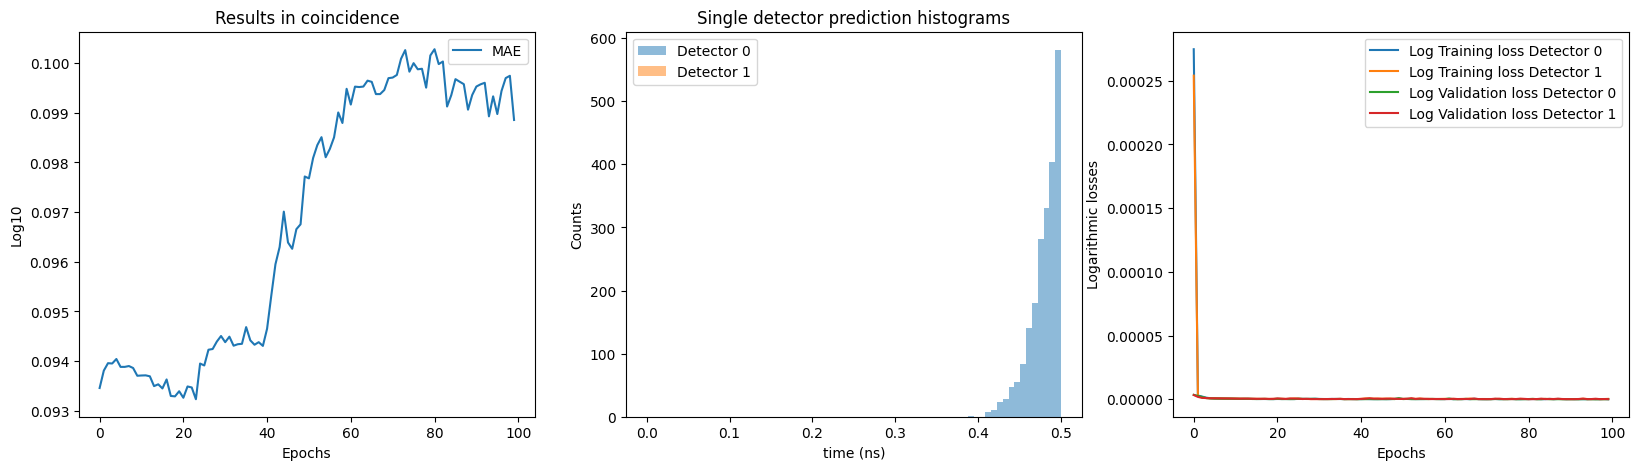

In [179]:
# Plot
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.plot(MAE, label = 'MAE')
plt.title('Results in coincidence')
plt.xlabel('Epochs')
plt.ylabel('Log10')
plt.legend()

plt.subplot(132)
plt.hist(test_dec0[-1,:], bins = nbins, range = [0, 0.5], alpha = 0.5, label = 'Detector 0');
plt.hist(test_dec1[-1,:], bins = nbins, range = [0, 0.5], alpha = 0.5, label = 'Detector 1');
plt.title('Single detector prediction histograms')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.legend()

plt.subplot(133)
plt.plot(loss_dec0, label = 'Log Training loss Detector 0')
plt.plot(loss_dec1, label = 'Log Training loss Detector 1')
plt.plot(val_loss_dec0, label = 'Log Validation loss Detector 0')
plt.plot(val_loss_dec1, label = 'Log Validation loss Detector 1')
plt.ylabel('Logarithmic losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

V20: CENTROID(ns) = 0.1819 +/- 0.00106  FWHM(ns) = 0.2754 +/- 0.00117
V00: CENTROID(ns) = 0.0003 +/- 0.00113  FWHM(ns) = 0.2894 +/- 0.00125
V02: CENTROID(ns) = -0.1942 +/- 0.00106  FWHM(ns) = 0.2762 +/- 0.00117



Text(0, 0.5, 'Counts')

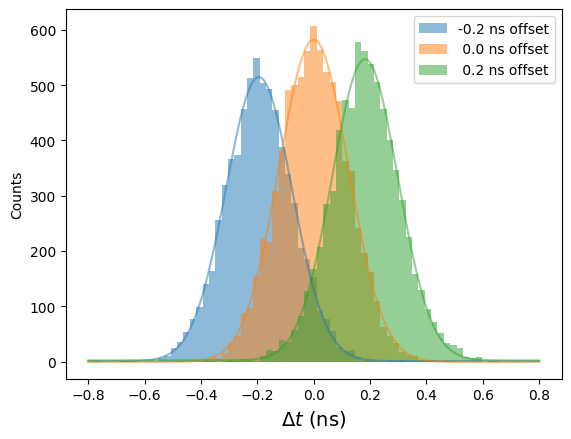

In [180]:
# Histogram and gaussian fit 
plot_gaussian(TOF_V02[-1,:], centroid_V00[-1], range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_V00[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_V20[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.2 ns offset', nbins = nbins)

params_V02, errors_V02 = get_gaussian_params(TOF_V02[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_V00[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_V20[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)

print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)', fontsize = 14)
plt.ylabel('Counts')

In [181]:
centroid_V00 = calculate_gaussian_center(TOF_V00, nbins = nbins, limits = 3) 
centroid_V02 = calculate_gaussian_center(TOF_V02 - centroid_V00[:, np.newaxis], nbins = nbins, limits = 3) 
centroid_V20 = calculate_gaussian_center(TOF_V20 - centroid_V00[:, np.newaxis], nbins = nbins, limits = 3)

error_V20_centroid = abs(centroid_V20 - 0.2)
error_V02_centroid = abs(centroid_V02 + 0.2)

avg_bias = np.mean(np.stack((error_V20_centroid , error_V02_centroid), axis = -1), axis = 1)

In [182]:
#Plot MAE_singles vs MAE_coincidences
err_val_dec0 = abs(val_dec0[:,:,0] - val_dec0[:,:,1] - REF_val_dec0[np.newaxis,:])
err_val_dec1 = abs(val_dec1[:,:,0] - val_dec1[:,:,1] - REF_val_dec1[np.newaxis,:])
mean_err_val_dec0 = np.mean(err_val_dec0, axis = 1)
mean_err_val_dec1 = np.mean(err_val_dec1, axis = 1)
square_sum = np.sqrt(mean_err_val_dec0.astype(np.float32)**2 + mean_err_val_dec1.astype(np.float32)**2)
epochs = np.arange(len(square_sum)) 

CTR = []
for i in range(epochs.shape[0]):
    params_V02, errors_V02 = get_gaussian_params(TOF_V02[i,:], centroid_V00[i], range = 0.8, nbins = nbins)
    params_V00, errors_V00 = get_gaussian_params(TOF_V00[i,:], centroid_V00[i], range = 0.8, nbins = nbins)
    params_V20, errors_V20 = get_gaussian_params(TOF_V20[i,:], centroid_V00[i], range = 0.8, nbins = nbins)
    CTR.append(np.mean([params_V20[3],params_V00[3],params_V02[3]]))
CTR = np.array(CTR)

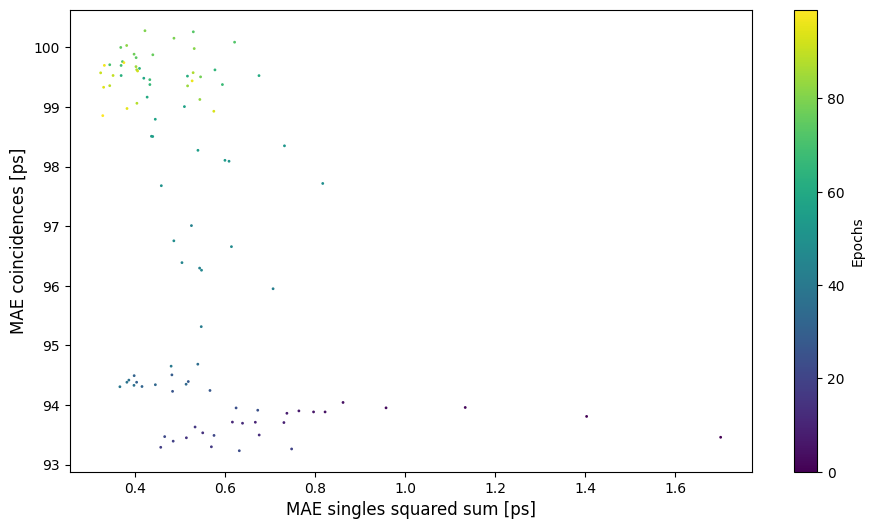

In [183]:
# Square sum vs MAE
plt.figure(figsize=(11,6))
plt.scatter(square_sum*1000, MAE*1000,  s = 1, c = epochs, cmap =  'viridis')
plt.xlabel('MAE singles squared sum [ps]', fontsize = 12)
plt.ylabel('MAE coincidences [ps]', fontsize = 12)
plt.colorbar(label = 'Epochs')  # Add a colorbar to show mapping

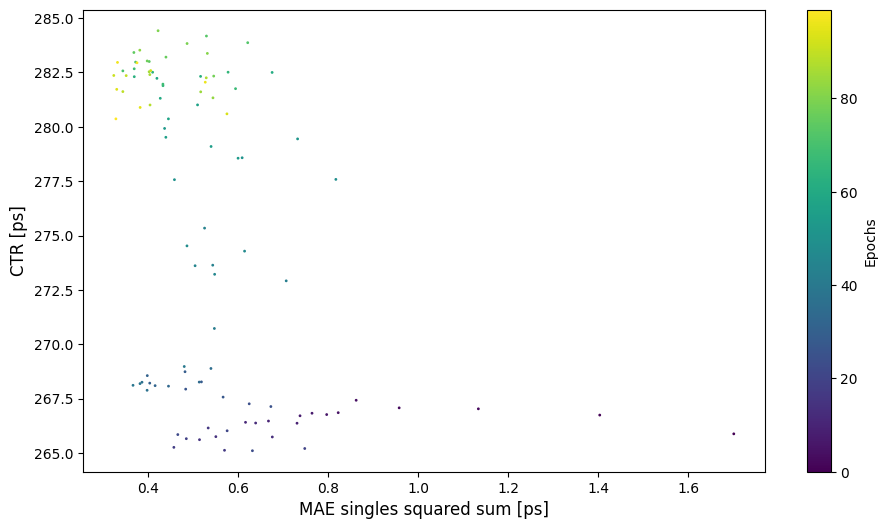

In [184]:
# Square sum vs MAE
plt.figure(figsize=(11,6))
plt.scatter(square_sum*1000, CTR*1000,  s = 1, c = epochs, cmap =  'viridis')
plt.xlabel('MAE singles squared sum [ps]', fontsize = 12)
plt.ylabel('CTR [ps]', fontsize = 12)
plt.colorbar(label = 'Epochs')  # Add a colorbar to show mapping

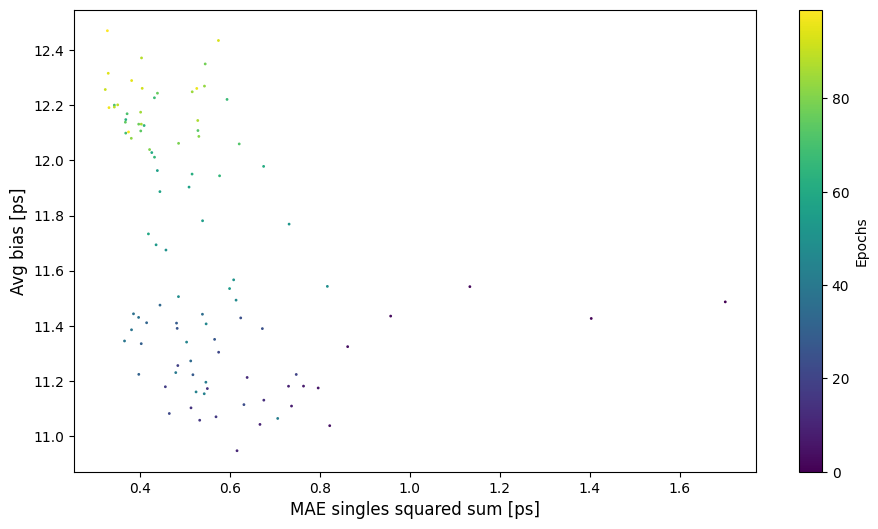

In [185]:
# Square sum vs MAE
plt.figure(figsize=(11,6))
plt.scatter(square_sum*1000, avg_bias*1000,  s = 1, c = epochs, cmap =  'viridis')
plt.xlabel('MAE singles squared sum [ps]', fontsize = 12)
plt.ylabel('Avg bias [ps]', fontsize = 12)
plt.colorbar(label = 'Epochs')  # Add a colorbar to show mapping